In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.Connection('./data/im.db')

## Table names from the Im.db database file.
A list of table names from the Database. I will use this to make a dictionary whose keys are the
table names and whose values are dataframe objects read from those tables.

In [3]:
q = ("""
     SELECT name
     AS 'Table Names'
     FROM sqlite_master
     WHERE type='table';

     """)
table_names = pd.read_sql(q, con)
table_names

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Sql Query Function
I wrote this function to take in a list of strings, form a valid sql query and then return the 
result of that query in a Pandas DataFrame object.

In [4]:

def sql_select(table, col_names, cond=None, group=None, having=None, order=None, limit=None):
    s_func = f"SELECT {col_names}\nFROM {table}"
    ending = ""
    if cond != None:
        ending = "\nWHERE " + cond
    if group != None:
        ending += "\nGROUP BY " + group
    if having != None:
        ending += "\nHAVING " + having
    if order != None:
        ending += "\nORDER BY " + order
    if limit != None:
        ending += "\nLIMIT " + limit
    ending += ";"
    query = s_func + ending
    return pd.read_sql(query, con)       

### Initializing the Dicitonary
I am using a dictionary comprehension function to create the dictionary containing Key, value
pairs of the table name and the corresponding DataFrame objects.

In [5]:
tables = {k: sql_select(k, "*") for k in table_names['Table Names'].to_list()}

Checking the dicitonary object for correctness.

In [6]:
len(tables)
list(tables.keys())

['movie_basics',
 'directors',
 'known_for',
 'movie_akas',
 'movie_ratings',
 'persons',
 'principals',
 'writers']

### The next step: EDA
The next step is doing some exploratory data analysis to look for interesting patterns or facts
in the data. I think I will probably go about this by just inspecting each table individually
and then deciding on a particular attribute to focus in on or compare/correlate/investigate in
relation to other column values in the dataset.

In [7]:
list(tables['movie_ratings'].columns)

[(table, list(tables[table].columns)) for table in tables.keys()]

[('movie_basics',
  ['movie_id',
   'primary_title',
   'original_title',
   'start_year',
   'runtime_minutes',
   'genres']),
 ('directors', ['movie_id', 'person_id']),
 ('known_for', ['person_id', 'movie_id']),
 ('movie_akas',
  ['movie_id',
   'ordering',
   'title',
   'region',
   'language',
   'types',
   'attributes',
   'is_original_title']),
 ('movie_ratings', ['movie_id', 'averagerating', 'numvotes']),
 ('persons',
  ['person_id',
   'primary_name',
   'birth_year',
   'death_year',
   'primary_profession']),
 ('principals',
  ['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']),
 ('writers', ['movie_id', 'person_id'])]

### Other Data Soruces
Now that I can see the basic struture of the imdb information I wan to move on to other datasets
and look for what information there might be interesting to compare to what is contained in my
dictionary object.
--------------------------------------------------------------

**Let's pull those other datasources into our dictionary:**

In [8]:
tables['movie_gross'] = pd.read_csv('./data/bom.movie_gross.csv')
tables['tmbd'] = pd.read_csv('./data/tmdb.movies.csv')
tables['movie_budgets'] = pd.read_csv('./data/tn.movie_budgets.csv')
tables['movie_reviews'] = pd.read_table('./data/rt.reviews.tsv', delimiter='\t',  header=0, encoding='unicode_escape')
tables['movie_info'] = pd.read_table('./data/rt.movie_info.tsv')

## Table of Contents
**_Here I created a class_** to take in a dictionary of datasets and return the Table of contents for
that dictionary. 

The `__init__` function takes in a dictionary with table names as the keys, and
DataFrame objects as the values. Then it makes a new dictionary with a list of the column names
from each table as the values, and the associated table names as keys.

I think the combination of the dict `tables` containing all my datasets and the Table of Contents
class could be more useful if merged into a single class. The TOC is nice but it's only purpose at
the moment is to provide a print-out of everything at once. Doing something similar to just having
each table in it's own Pandas DataFrame object (which they still are actually) and then going cell
by cell and printing them all out. While it's nice to be able to see it all at once I think having
a class that takes in the tables and stores a dictionary on them, but also incorporates methods for
accessing and interacting with them in a more streamlined way beyond just printing a formatted
overview would be a really great tool to have.

Such a tool might provide:
  - Automated methods for basic analysis
  - Comparing, and viewing tables or columns across tables
  - Labeling and extending the functionality built-into Pandas Dataframes
  - inserting and removing tables
  - Tools to automatically manage an SQL connection

It seems like this is probaly something someone has already built or is maybe not practical on a
more regular basis, but this is the direction my mind went working with this particular set of 
tables where a lot of merge and cleaning needed to happen across several separate tables.

It was also nice to be able to treat all of the tables syntactically like a single database or
Pandas object.

In [9]:
class Table_of_Contents():
    def __init__(self, dict):
        self.data_dict = {table: list(dict[table].columns) for table in tables.keys()}

    def __repr__(self):
        str_out = "Table of Contents\n"
        for k, v in self.data_dict.items():
            str_out += "\n" + k + "\n"
            for num, col_name in enumerate(v):
               str_out += str(num) + ".." + col_name + "\n"
        return str_out 

### Initializing a TOC Object
**Now** we can initialize the Table of Contents object and get a more readable look at what is
inside our full dataset.

In [10]:
[np.typename(np.sctype2char(x)) for x in tables['movie_basics'].dtypes]

['object',
 'object',
 'object',
 'long long integer',
 'double precision',
 'object']

In [11]:
movie_toc = Table_of_Contents(tables)
print(movie_toc)

Table of Contents

movie_basics
0..movie_id
1..primary_title
2..original_title
3..start_year
4..runtime_minutes
5..genres

directors
0..movie_id
1..person_id

known_for
0..person_id
1..movie_id

movie_akas
0..movie_id
1..ordering
2..title
3..region
4..language
5..types
6..attributes
7..is_original_title

movie_ratings
0..movie_id
1..averagerating
2..numvotes

persons
0..person_id
1..primary_name
2..birth_year
3..death_year
4..primary_profession

principals
0..movie_id
1..ordering
2..person_id
3..category
4..job
5..characters

writers
0..movie_id
1..person_id

movie_gross
0..title
1..studio
2..domestic_gross
3..foreign_gross
4..year

tmbd
0..Unnamed: 0
1..genre_ids
2..id
3..original_language
4..original_title
5..popularity
6..release_date
7..title
8..vote_average
9..vote_count

movie_budgets
0..id
1..release_date
2..movie
3..production_budget
4..domestic_gross
5..worldwide_gross

movie_reviews
0..id
1..review
2..rating
3..fresh
4..critic
5..top_critic
6..publisher
7..date

movie_info
0.

Now that there is a good way to inspect our basic data structure .
I can start searching for and inspecting the contents to identify the merges and joins I need to 
execute to be able to start analyzing the relationships I'm interested in exploring.

**_Note:_** I would like to follow up and expand this class to print and store datatypes and other
useful information about each table/columnn.

In [12]:
tables['movie_basics'].head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [13]:
m_grouped_by_p = tables['known_for'].groupby('person_id')['movie_id'].apply(list).reset_index()

In [14]:
persons_plus_movies = tables['persons'].merge(m_grouped_by_p, on='person_id')
persons_plus_movies.head()

,person_id,primary_name,birth_year,death_year,primary_profession,movie_id
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","[tt0837562, tt2398241, tt0844471, tt0118553]"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","[tt0896534, tt6791238, tt0287072, tt1682940]"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","[tt1470654, tt0363631, tt0104030, tt0102898]"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","[tt0114371, tt2004304, tt1618448, tt1224387]"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","[tt0452644, tt0452692, tt3458030, tt2178256]"


In [15]:
persons_plus_movies['primary_profession'] = persons_plus_movies['primary_profession'].map(lambda x : x.split(','), na_action='ignore')
persons_plus_movies.head()

,person_id,primary_name,birth_year,death_year,primary_profession,movie_id
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"[miscellaneous, production_manager, producer]","[tt0837562, tt2398241, tt0844471, tt0118553]"
1,nm0061865,Joseph Bauer,NaN,NaN,"[composer, music_department, sound_department]","[tt0896534, tt6791238, tt0287072, tt1682940]"
2,nm0062070,Bruce Baum,NaN,NaN,"[miscellaneous, actor, writer]","[tt1470654, tt0363631, tt0104030, tt0102898]"
3,nm0062195,Axel Baumann,NaN,NaN,"[camera_department, cinematographer, art_depar...","[tt0114371, tt2004304, tt1618448, tt1224387]"
4,nm0062798,Pete Baxter,NaN,NaN,"[production_designer, art_department, set_deco...","[tt0452644, tt0452692, tt3458030, tt2178256]"


#### Note to self: Refocus
## 
Okay what I need to do to finish this line of thought is get a list of movies where one or more of
the credited actors dies within 0 - 2 years of the film being released. Then I need to compare the
median gross of that film to the median gross of other films from the same time period where there
was not a death associated with the release.

1. First step in this process is adding a column to the `persons_plus_movies` table that grabs the
   release dates from each of the movies listed in their `movie_id` column.

2. The second step will be to calculate the mininum value of the difference between the date of
   their death and the release date of each of their films.

In [16]:
def find_movies(id_list):
    result = []
    for movie in id_list:
        try:
            title = tables['movie_basics'][tables['movie_basics']['movie_id'] == movie]['primary_title'].to_list()
            year = tables['movie_basics'][tables['movie_basics']['movie_id'] == movie]['start_year'].to_list()
            entry = (title[0], str(year[0]))
            if title:
                result.append(entry)
        except TypeError and LookupError:
            pass
    return result

In [17]:
find_movies(persons_plus_movies['movie_id'][0])

[('Hotel Transylvania', '2012'), ('Smurfs: The Lost Village', '2017')]

## Adjusting Course
At this point I need some course correction. The EDA in the direction I have been following is going
to be more involved and turned out to be a little less practical given the limited timeframe covered
by this dataset.

Instead I am going to focus on the following and see what I can accomplish befor the deadline:
Popular Genres > Budget to Profit > Most adavantageous season for genre

In [18]:
primary_df = tables['movie_basics']
primary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


## Merges and Joins
I have a `primary_df` now with gernres split into a list. Now I want to start joining in the data
from other tables that I want to use.
  - Budget
  - Reviews or some other marker of popularity
  - Domestic & Foreign Grosses
  - More accurate release date (that includes month)

In [19]:
tables['movie_ratings']
primary_df = primary_df.merge(tables['movie_ratings'], on='movie_id')

In [20]:
budgets = tables['movie_budgets'][['release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']].rename(columns={'movie':'primary_title'})
budgets
primary_df = primary_df.merge(budgets, on='primary_title', how='left')

In [21]:
gross = tables['movie_gross'][['title', 'studio', 'domestic_gross', 'foreign_gross']].rename(columns={'title':'primary_title'})
primary_df = primary_df.merge(gross, on='primary_title', how='left', suffixes=('_x','_y'))

In [22]:
primary_df[primary_df['domestic_gross_x'].notna()]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,release_date,production_budget,domestic_gross_x,worldwide_gross,studio,domestic_gross_y,foreign_gross
16,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,"Dec 31, 2012","$45,000,000",$0,"$73,706",NaN,NaN,NaN
33,tt0326592,The Overnight,The Overnight,2010,88.0,None,7.5,24,"Jun 19, 2015","$200,000","$1,109,808","$1,165,996",NaN,NaN,NaN
41,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302",IFC,744000.0,8000000
47,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183",Fox,58200000.0,129900000
51,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587",Uni.,26300000.0,26900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73774,tt9746500,Earth,Erde,2019,115.0,Documentary,7.3,49,"Apr 22, 2009","$47,000,000","$32,011,576","$116,773,317",NaN,NaN,NaN
73900,tt9851050,Sisters,Sisters,2019,NaN,"Action,Drama",4.7,14,"Dec 18, 2015","$30,000,000","$87,044,645","$106,030,660",Uni.,87000000.0,18000000
73915,tt9861522,Ali,Ali,2019,110.0,Drama,7.7,79,"Dec 25, 2001","$109,000,000","$58,183,966","$87,683,966",NaN,NaN,NaN
73957,tt9899880,Columbus,Columbus,2018,85.0,Comedy,5.8,5,"Aug 4, 2017","$700,000","$1,017,107","$1,110,511",NaN,NaN,NaN


#### Note to self: Refocus!
## Next Step
Below I am defining a function that will compare two values from the separately sourced `domestic_gross`
data Series and return the non-NaN value from the two. This way if there is overlap it will favor
the "left-hand" column. I will use it as the sorting function in the Pandas buitlin method `combine`.

In [23]:
def swap_check(x, y):
    if pd.notna(x):
        return x
    elif pd.notna(y):
        return y
    else:
        pass

In [24]:
one = primary_df['domestic_gross_x'].astype('int64', errors='ignore')
two = primary_df['domestic_gross_y'].astype('int64', errors='ignore')
one = one.str.strip('$,')
one = one.str.replace(',','')
one.sort_values()

16         0
15291      0
15392      0
64544      0
15411      0
        ... 
73976    NaN
73977    NaN
73978    NaN
73979    NaN
73980    NaN
Name: domestic_gross_x, Length: 73981, dtype: object

### Fill NaNs Function 
This function was written to replace placeholder values in the two columns with NaN values. I was
having an issue with sorting and combining these two columns because some placeholder values where
"0" value string objects and therefore would not be identified correctly when merging the two data
series.

Once all invalid entries have been converted to NaN the two columns can be merged with a simple
comparator function (`swap_check`).

In [25]:
def fill_nan(x):
    if x == 0:
        x = np.nan
        return x
    else:
        return x

In [26]:
one = one.map(lambda x : int(x), na_action='ignore')
two = two.map(lambda x : int(x), na_action='ignore')
one = one.map(fill_nan, na_action='ignore')
two = two.map(fill_nan, na_action='ignore')
combined_gross = one.combine(two, swap_check)

In [27]:
prod_budget = primary_df['production_budget']
prod_budget = prod_budget.str.replace(',','').str.strip('$').astype('float')
primary_df['production_budget'] = prod_budget

**_Remerge_** `domestic_gross`

In [28]:
primary_df['domestic_gross'] = combined_gross

In [29]:
n_final_df = primary_df.drop(columns=['domestic_gross_y','domestic_gross_x'])

Check the Production Budget column for non NAN values and the add a column `point_per_dollar` that
returns a ratio of the `ratings` and the `production_budget` column.

In [30]:
n_final_df[n_final_df['production_budget'].notna()]['production_budget']
n_final_df['point_per_dollar'] = n_final_df.apply(lambda x : (x['averagerating']/x['production_budget'])*1000000, axis=1)

Convert `release_date` column into datetime objects.

In [31]:
n_final_df['release_date'] = n_final_df['release_date'].map(lambda x : pd.to_datetime(x), na_action='ignore')
n_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73981 entries, 0 to 73980
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           73981 non-null  object        
 1   primary_title      73981 non-null  object        
 2   original_title     73981 non-null  object        
 3   start_year         73981 non-null  int64         
 4   runtime_minutes    66350 non-null  float64       
 5   genres             73176 non-null  object        
 6   averagerating      73981 non-null  float64       
 7   numvotes           73981 non-null  int64         
 8   release_date       2875 non-null   datetime64[ns]
 9   production_budget  2875 non-null   float64       
 10  worldwide_gross    2875 non-null   object        
 11  studio             3044 non-null   object        
 12  foreign_gross      1849 non-null   object        
 13  domestic_gross     4103 non-null   float64       
 14  point_

### Genre Filter Function
The following function takes a series that contains lists and returns the rows that contain the
search term.

In [32]:
def return_genre(genres_list, term):
    if genres_list is np.nan:
        return False
    else:
        try:
            return term in genres_list
        except TypeError:
            return False

## Sorting by Genre
Below I am assigning variables to hold the genre sorted data. Something to note about this approach
verses a `groupby` method that chooses one genre per title this function will sort any movie with
the genre search term in its list of genres will be pulled in by the filter. To me this seems like
a better way to compare genres than to make an ultimately arbitrary decision about the genre into
which a movie should be sorted. It will result in some movies being compared to themselves across
genre, but my intution is that this actually provides a more direct comparison over the entire set
of data.

Of course, I could be wrong. Would be interested in knowing how people who have thought through these
situations more carefully or systematically think about dealing with them.

In [33]:
action = n_final_df[n_final_df['genres'].apply(return_genre, args=("Action",))]
romance = n_final_df[n_final_df['genres'].apply(return_genre, args=("Romance",))]
crime = n_final_df[n_final_df['genres'].apply(return_genre, args=("Crime",))]
comedy = n_final_df[n_final_df['genres'].apply(return_genre, args=("Comedy",))]
drama = n_final_df[n_final_df['genres'].apply(return_genre, args=("Drama",))]

In [34]:
# Groups by Year and Genre
# Action Movie Groups by Year
tot_a_gross_by_year = action.groupby('start_year')['domestic_gross'].sum()
list_a_gross_by_year = action.dropna(axis=0, how='any', subset=['domestic_gross'])
list_a_gross_by_year = list_a_gross_by_year.groupby('start_year')['domestic_gross'].apply(list)
med_a_rating_by_year = action.groupby('start_year')['averagerating'].median()
med_a_avggross_by_year = action.groupby('start_year')['domestic_gross'].median()
med_action_prd_bgt_by_year = action.groupby('start_year')['production_budget'].median()

# Romance movie Groups by Year
tot_r_gross_by_year = romance.groupby('start_year')['domestic_gross'].sum()
med_r_rating_by_year = romance.groupby('start_year')['averagerating'].median()
med_r_avggross_by_year = romance.groupby('start_year')['domestic_gross'].median()
med_romance_prd_bgt_by_year = romance.groupby('start_year')['production_budget'].median()

# Crime movie Groups by Year
tot_c_gross_by_year = crime.groupby('start_year')['domestic_gross'].sum()
med_c_rating_by_year = crime.groupby('start_year')['averagerating'].median()
med_c_avggross_by_year = crime.groupby('start_year')['domestic_gross'].median()
med_crime_prd_bgt_by_year = crime.groupby('start_year')['production_budget'].median()

# Drama movie Groups by Year
tot_d_gross_by_year = drama.groupby('start_year')['domestic_gross'].sum()
list_d_gross_by_year = drama.dropna(axis=0, how='any', subset=['domestic_gross'])
list_d_gross_by_year = list_d_gross_by_year.groupby('start_year')['domestic_gross'].apply(list)
med_d_rating_by_year = drama.groupby('start_year')['averagerating'].median()
med_d_avggross_by_year = drama.groupby('start_year')['domestic_gross'].median()
med_drama_prd_bgt_by_year = drama.groupby('start_year')['production_budget'].median()

# Comedy movie Groups by Year
tot_l_gross_by_year = comedy.groupby('start_year')['domestic_gross'].sum()
med_l_rating_by_year = comedy.groupby('start_year')['averagerating'].median()
med_l_avggross_by_year = comedy.groupby('start_year')['domestic_gross'].median()
med_comedy_prd_bgt_by_year = comedy.groupby('start_year')['production_budget'].median()

## Total Box Office by Genre
Below I am laying out a bar plot that compares total genre marketshare between movies. This will
be important to establish areas of interest and where it will be most beneficial to frame further
analysis.

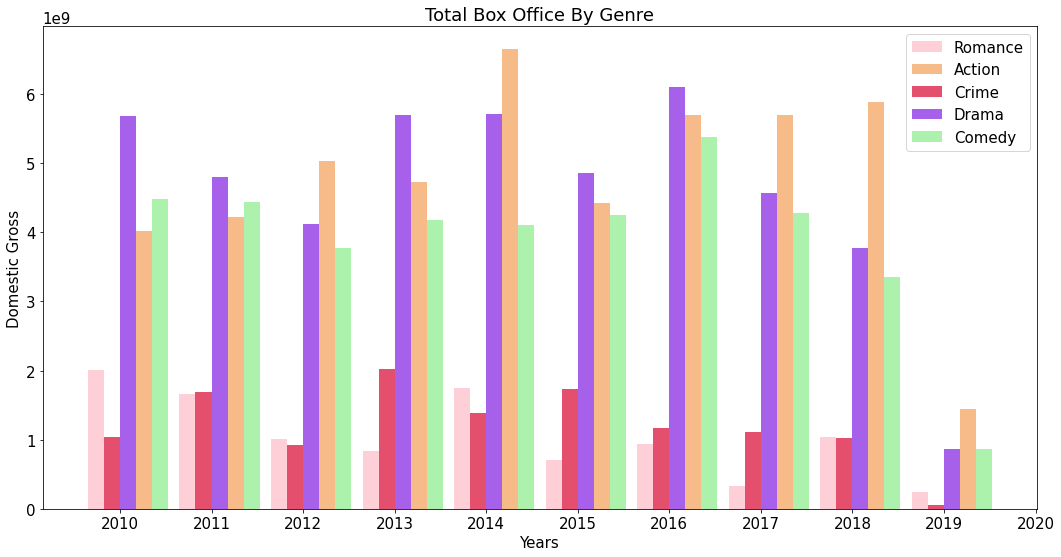

In [35]:
# Setting some matplotlib options to improve the plot output.
width = .35
plt.rcParams.update({'font.size': 15})

# Defining the plot
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.bar(tot_r_gross_by_year.index - width*.75, tot_r_gross_by_year, width/2, label="Romance", color="pink", alpha=.75, zorder=10)
ax.bar(tot_a_gross_by_year.index + width*.75, tot_a_gross_by_year, width/2, label="Action", color="sandybrown", alpha=.75, zorder=10)
ax.bar(tot_c_gross_by_year.index - width/4, tot_c_gross_by_year, width/2, label="Crime", color="crimson", alpha=.75, zorder=10)
ax.bar(tot_d_gross_by_year.index + width/4, tot_d_gross_by_year, width/2, label="Drama", color="blueviolet", alpha=.75, zorder=10)
ax.bar(tot_l_gross_by_year.index + width+width*.25, tot_l_gross_by_year, width/2, label="Comedy", color="lightgreen", alpha=.75, zorder=10)

ax.set_title('Total Box Office By Genre')
ax.set_xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
ax.set_xlabel('Years')
ax.set_ylabel('Domestic Gross')
ax.legend()

fig.tight_layout()
plt.show()

## Dollar per Rating point by Genre
Here I am going to determine how much a studio spends per point of the rating scale.

Below I am downsampling the data a bit to make a more readable visualization. I am also reducing
filtering rows and droping na values that might interfere with calculations.

In [36]:
sample_size = 100
action_data = action[['release_date', 'averagerating', 'production_budget', 'point_per_dollar']].dropna(axis=0, how='any')
action_data = action_data[(action_data['release_date'] > pd.to_datetime('1/1/2010')) & (action_data['point_per_dollar'] < 2 )].sample(sample_size)
action_data = action_data.sort_values('release_date')
drama_data = drama[['release_date', 'averagerating', 'production_budget', 'point_per_dollar']].dropna(axis=0, how='any')
drama_data = drama_data[(drama_data['release_date'] > pd.to_datetime('1/1/2010')) & (drama_data['point_per_dollar'] < 2 )].sample(sample_size)
comedy_data = comedy[['release_date', 'averagerating', 'production_budget', 'point_per_dollar']].dropna(axis=0, how='any')
comedy_data = comedy_data[(comedy_data['release_date'] > pd.to_datetime('1/1/2010')) & (comedy_data['point_per_dollar'] < 2)].sample(sample_size)
romance_data = romance[['release_date', 'averagerating', 'production_budget', 'point_per_dollar']].dropna(axis=0, how='any')
romance_data = romance_data[(romance_data['release_date'] > pd.to_datetime('1/1/2010')) & (romance_data['point_per_dollar'] < 2)].sample(sample_size)
crime_data = crime[['release_date', 'averagerating', 'production_budget', 'point_per_dollar']].dropna(axis=0, how='any')
crime_data = crime_data[(crime_data['release_date'] > pd.to_datetime('1/1/2010')) & (crime_data['point_per_dollar'] < 2)].sample(sample_size)

No handles with labels found to put in legend.


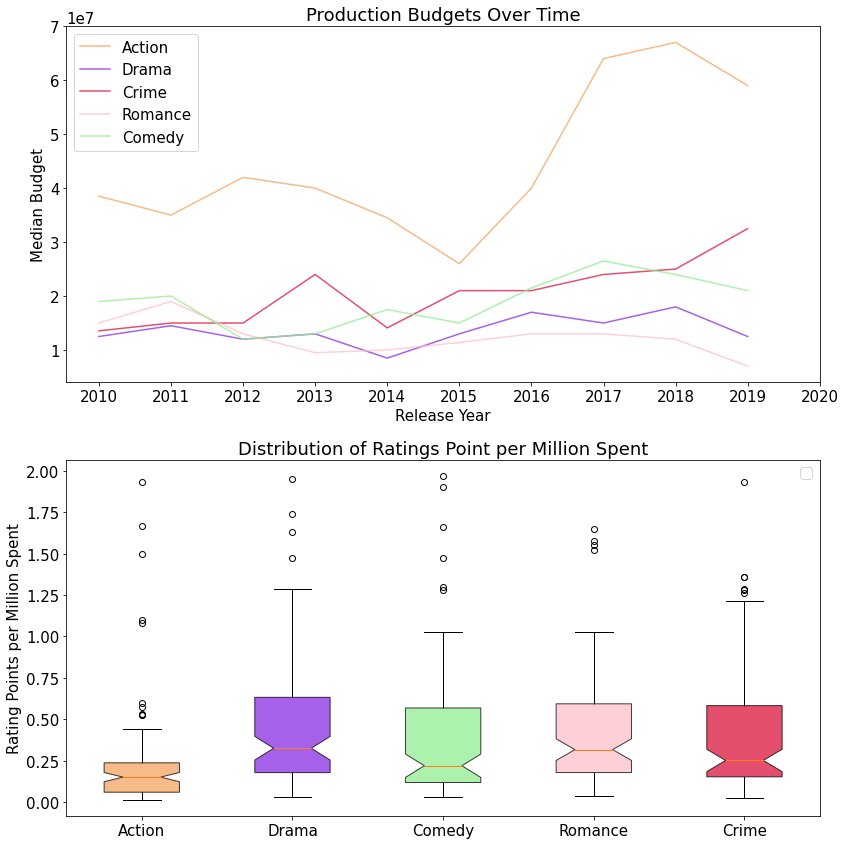

In [37]:
fig2, ax2 = plt.subplots(2, 1, figsize=(12,12))

ax2[0].plot(med_action_prd_bgt_by_year, color='sandybrown', alpha=.75, label='Action')
ax2[0].plot(med_drama_prd_bgt_by_year,color='blueviolet', alpha=.75, label='Drama')
ax2[0].plot(med_crime_prd_bgt_by_year, color='crimson', alpha=.75, label='Crime')
ax2[0].plot(med_romance_prd_bgt_by_year, color='pink', alpha=.75, label='Romance')
ax2[0].plot(med_comedy_prd_bgt_by_year, color='lightgreen', alpha=.75, label='Comedy')

ax2[0].set_xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
ax2[0].set_xlabel('Release Year')
ax2[0].set_ylabel('Median Budget')
ax2[0].set_title('Production Budgets Over Time')
ax2[0].legend()

# ------------------------------------------------------------------------------------
# Below I define the boxplots and use a for loop
# to loop through the `patch` artist object and
# set each boxes color styling and alpha valuesk

box_labels = ["Action", "Drama", "Comedy", "Romance", "Crime"]
box_data = [action_data['point_per_dollar'],drama_data['point_per_dollar'], comedy_data['point_per_dollar'],romance_data['point_per_dollar'],crime_data['point_per_dollar']]
bplot = ax2[1].boxplot(box_data, labels=box_labels, patch_artist=True, notch=True)
colors = ['sandybrown', 'blueviolet', 'lightgreen', 'pink', 'crimson']
for plot in bplot:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(.75)
        patch.set_joinstyle('round')
ax2[1].set_title('Distribution of Ratings Point per Million Spent')
ax2[1].set_ylabel('Rating Points per Million Spent')
ax2[1].legend()
plt.tight_layout()
plt.show()

### Stacked Bar Plot
Here I am defining a stacked bar plot to compare aggregate values from each genre groups and
color the aggregates to show rough distributions of individual titles wthin each aggregated
bar.

In [38]:
def build_graph(df, colors, category=""):
    x_names = df.index.to_list()
    fig, ax = plt.subplots(figsize=(8,5))
    for row in x_names:
        stack = 0
        for index, part in enumerate(df[row]):
            c_ind = index
            if c_ind > len(colors) - 1:
                c_ind = round(index/len(df[row]) * (len(colors) - 1))
            ax.bar(row, part, bottom= stack,width=.5, color=colors[c_ind])
            stack += part
    ax.set_xticks(x_names)
    ax.set_ylabel('Domestic Gross\n in 100\'s of Millions')
    ax.set_xlabel('Years')
    ax.set_title(f'{category} Movie Grosses By Year')
    return fig, ax 

## Comparisons of Distribution
Now that the function to construct the stacked bar plots is defined I can use it to feed in
my data from the genre groups. Above I assigned variables to hold the `groupby('year')` results
and aggregate them into a list. The function takes that list and the index column from the
groupby object and stacks each value in the bar graph. The function is purpose built for this
data but could be generalized fairly easily. 

Something that may be helpful in the future would
be to expand this function into a class definition that returns a plot and can be configured
similarly to a other matplotlib plot classes.

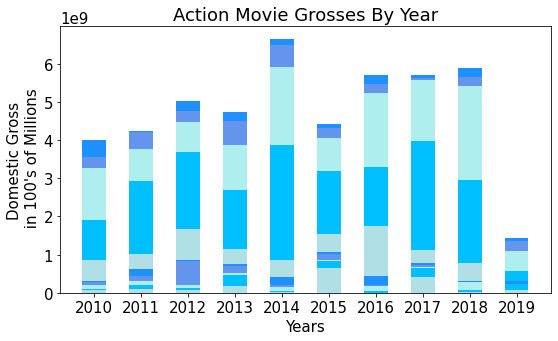

In [39]:
blue_colors = ['powderblue','deepskyblue','paleturquoise', 'cornflowerblue', 'dodgerblue']
build_graph(list_a_gross_by_year, blue_colors, "Action")
plt.tight_layout()
plt.show()

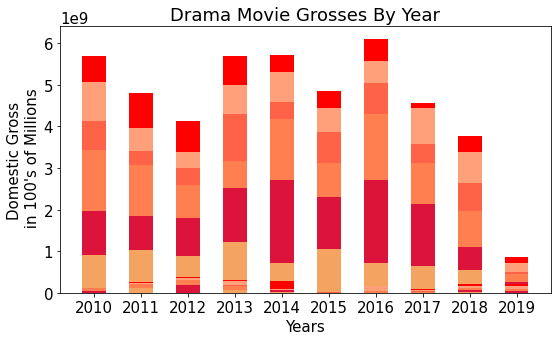

In [40]:
red_colors = ['sandybrown', 'crimson','coral', 'tomato','lightsalmon', 'red']
build_graph(list_d_gross_by_year, red_colors, "Drama")
plt.tight_layout()
plt.show()